<a href="https://colab.research.google.com/github/riddhikaa/sign_language/blob/main/Project_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="palak27"
os.environ["KAGGLE_KEY"] = "a9c6366cd0407ac517d026e146957691"
!kaggle datasets download vaishnaviasonawane/indian-sign-language-dataset

 96% 257M/268M [00:02<00:00, 118MB/s]
100% 268M/268M [00:02<00:00, 112MB/s]


In [ ]:
from IPython.display import clear_output
!unzip indian-sign-language-dataset.zip
clear_output()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
GENERATE_RES = 3 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH1 = '/content/data/1'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [ ]:
training_binary_path = os.path.join(DATA_PATH1,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH1)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/data/1/training_data_96_96.npy
Loading previous training pickle...


In [ ]:
train_dataset1 = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

In [ ]:
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape,
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

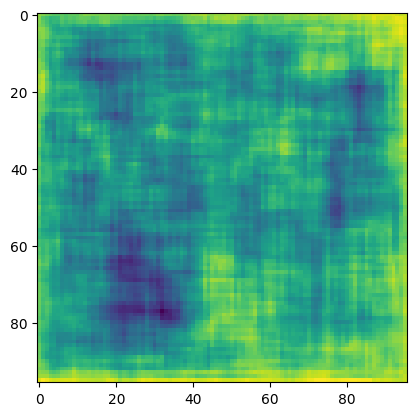

In [ ]:
def save_images(cnt,noise,datapath):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5
  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(datapath,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49945778]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs,datapath):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,datapath)

  elapsed = time.time()-start
  #print (f'Training time: {hms_string(elapsed)}')
train(train_dataset1, EPOCHS,DATA_PATH1)

Epoch 1, gen loss=3.246817111968994,disc loss=0.28474196791648865, {hms_string(epoch_elapsed)}
1/1 [==============================] - 1s 1s/step
Epoch 2, gen loss=4.002617359161377,disc loss=0.333858460187912, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 22ms/step
Epoch 3, gen loss=3.3750951290130615,disc loss=0.6667774319648743, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 39ms/step
Epoch 4, gen loss=3.2834253311157227,disc loss=0.6290008425712585, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 5, gen loss=3.2717089653015137,disc loss=0.5632085204124451, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 22ms/step
Epoch 6, gen loss=3.6445930004119873,disc loss=0.6868735551834106, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 7, gen loss=3.7645862102508545,disc loss=0.5008212924003601, {hms_string(epoch_elapsed)}
1/1 [======================

In [ ]:
images_len=os.listdir(DATA_PATH1)
len(images_len)

1202

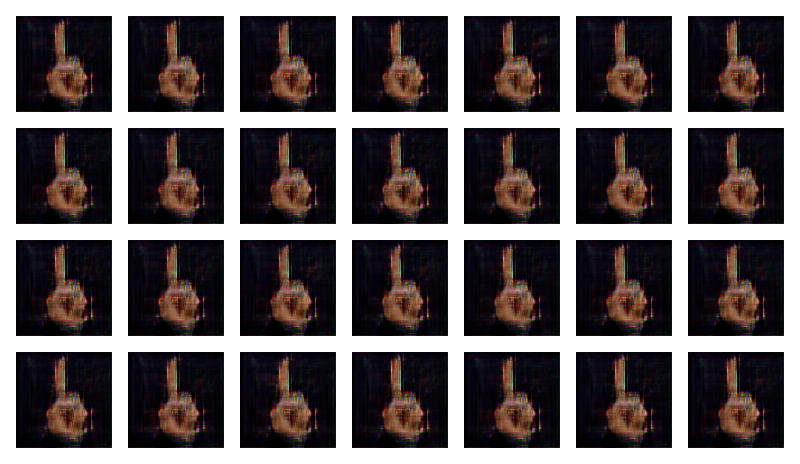

In [ ]:
imgpath="/content/data/1/output/train-22.png"
Image.open(imgpath)

In [ ]:
root_dir="/content/data"
class_names=os.listdir(root_dir)
for name in class_names:
  path=root_dir+"/"+name
  n_images=len(os.listdir(path))
  print(name," : ",n_images)

K  :  1200
V  :  1200
T  :  1200
S  :  1200
U  :  1200
I  :  1200
D  :  1200
F  :  1200
2  :  1200
1  :  1202
3  :  1200
4  :  1200
X  :  1200
H  :  1200
8  :  1200
7  :  1200
B  :  1200
Q  :  1200
C  :  1200
6  :  1200
A  :  1200
Z  :  1200
W  :  1200
M  :  1200
E  :  1200
O  :  1200
Y  :  1200
G  :  1200
R  :  1200
J  :  1200
N  :  1200
P  :  1200
L  :  1200
9  :  1200
5  :  1200


In [ ]:
DATA_PATH8="/content/data/8"
training_binary_path = os.path.join(DATA_PATH8,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH8)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/data/8/training_data_96_96.npy
Loading previous training pickle...


In [ ]:
train_dataset8 = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train(train_dataset8, EPOCHS,DATA_PATH8)

Epoch 1, gen loss=13.03331184387207,disc loss=2.7772607803344727, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 25ms/step
Epoch 2, gen loss=13.308600425720215,disc loss=1.5179802179336548, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 24ms/step
Epoch 3, gen loss=8.802772521972656,disc loss=0.45389851927757263, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 21ms/step
Epoch 4, gen loss=8.7682523727417,disc loss=0.6827210783958435, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 5, gen loss=6.4806718826293945,disc loss=0.20155096054077148, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 33ms/step
Epoch 6, gen loss=8.971090316772461,disc loss=0.3489588797092438, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 22ms/step
Epoch 7, gen loss=6.793511867523193,disc loss=0.1228465884923935, {hms_string(epoch_elapsed)}
1/1 [=======================

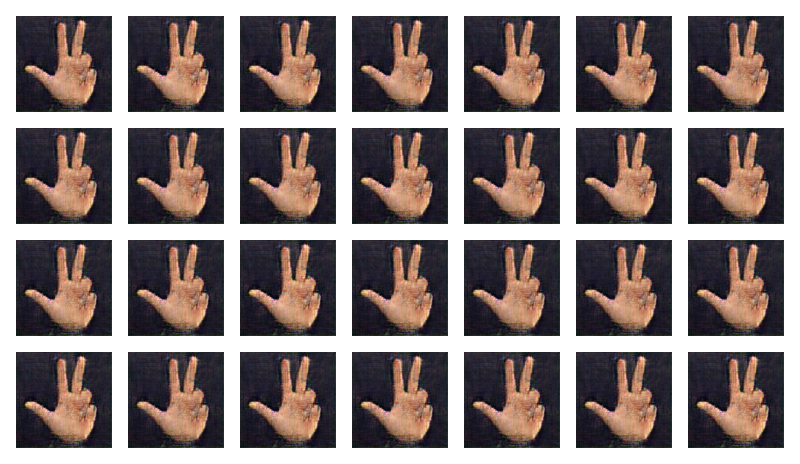

In [ ]:
imgpath="/content/data/8/output/train-23.png"
Image.open(imgpath)

In [ ]:
DATA_PATHM="/content/data/M"
training_binary_path = os.path.join(DATA_PATHM,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATHM)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/data/M/training_data_96_96.npy
Loading previous training pickle...


In [ ]:
train_datasetM= tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train(train_datasetM, EPOCHS,DATA_PATHM)

Epoch 1, gen loss=15.013026237487793,disc loss=4.623253345489502, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 27ms/step
Epoch 2, gen loss=9.457450866699219,disc loss=2.7655320167541504, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 3, gen loss=10.107806205749512,disc loss=2.360179901123047, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 4, gen loss=7.396190643310547,disc loss=1.9280169010162354, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 5, gen loss=7.894092082977295,disc loss=1.08977472782135, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 6, gen loss=5.96166467666626,disc loss=1.1696069240570068, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 25ms/step
Epoch 7, gen loss=5.890466213226318,disc loss=1.0606549978256226, {hms_string(epoch_elapsed)}
1/1 [============================

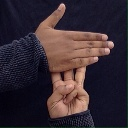

In [ ]:
imgpathm="/content/data/M/1005.jpg"
Image.open(imgpathm)

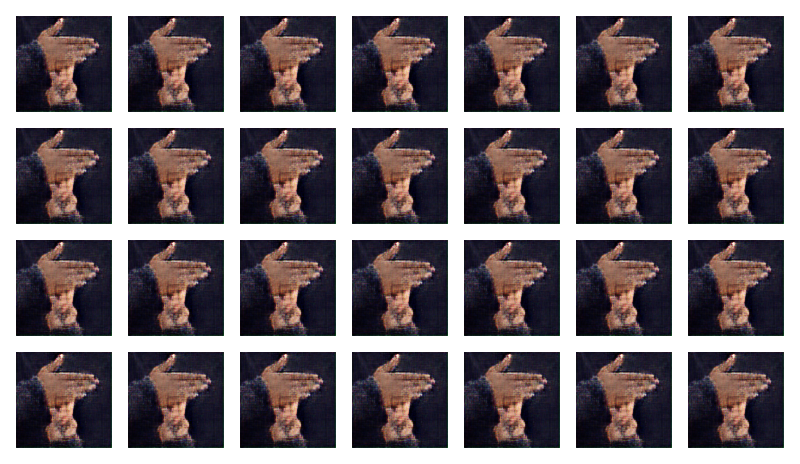

In [ ]:
imgpathm="/content/data/M/output/train-18.png"
Image.open(imgpathm)

In [ ]:
DATA_PATHE="/content/data/E"
training_binary_path = os.path.join(DATA_PATHE,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATHE)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/data/E/training_data_96_96.npy
Loading previous training pickle...


In [ ]:
train_datasetE= tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train(train_datasetE, EPOCHS,DATA_PATHE)

Epoch 1, gen loss=14.928338050842285,disc loss=5.890145778656006, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 28ms/step
Epoch 2, gen loss=13.65700626373291,disc loss=2.205828905105591, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 21ms/step
Epoch 3, gen loss=10.29983901977539,disc loss=1.085125207901001, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 4, gen loss=8.662494659423828,disc loss=0.7448608875274658, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 5, gen loss=7.917176723480225,disc loss=0.9866570830345154, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 6, gen loss=7.0446577072143555,disc loss=0.6531213521957397, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=6.5539445877075195,disc loss=0.5661983489990234, {hms_string(epoch_elapsed)}
1/1 [=========================

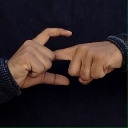

In [ ]:
imgpathe="/content/data/E/1005.jpg"
Image.open(imgpathe)

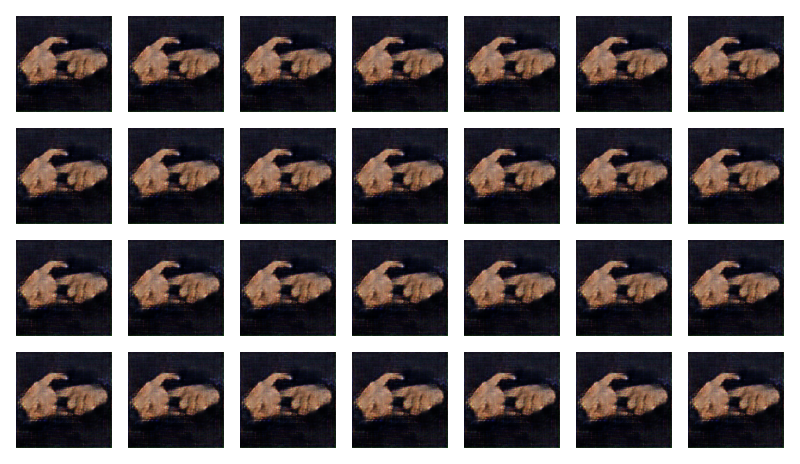

In [ ]:
imgpathoe="/content/data/E/output/train-13.png"
Image.open(imgpathoe)

In [ ]:
DATA_PATHQ="/content/data/Q"
training_binary_path = os.path.join(DATA_PATHQ,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATHQ)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/data/Q/training_data_96_96.npy
Loading previous training pickle...


In [ ]:
train_datasetQ= tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train(train_datasetQ, EPOCHS,DATA_PATHQ)

Epoch 1, gen loss=16.077856063842773,disc loss=3.522486925125122, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 2, gen loss=14.876680374145508,disc loss=2.9411916732788086, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 19ms/step
Epoch 3, gen loss=12.075467109680176,disc loss=1.9814103841781616, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=9.21345329284668,disc loss=1.7795321941375732, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 20ms/step
Epoch 5, gen loss=9.521841049194336,disc loss=1.1715710163116455, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 27ms/step
Epoch 6, gen loss=10.173108100891113,disc loss=1.2316182851791382, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=6.407949924468994,disc loss=0.7527761459350586, {hms_string(epoch_elapsed)}
1/1 [=======================

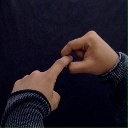

In [ ]:
imgpathq="/content/data/Q/1005.jpg"
Image.open(imgpathq)

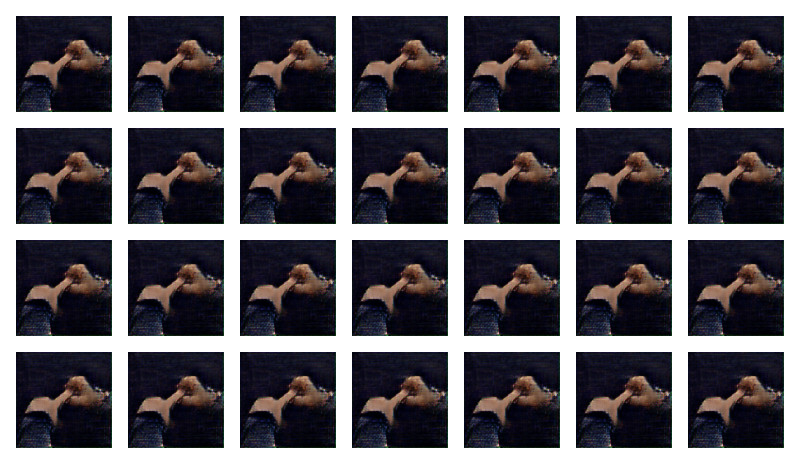

In [ ]:
imgpathoq="/content/data/Q/output/train-11.png"
Image.open(imgpathoq)

In [ ]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir="/content/data"
train_path=ImageDataGenerator(rescale=1/255.,
                              horizontal_flip=True,
                              shear_range=0.2,
                              zoom_range=0.2, )
valid_path=ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
train_data = train_path.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               color_mode='rgb',
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training')
valid_data = valid_path.flow_from_directory(train_dir,
                                           target_size=(224, 224),
                                           color_mode='rgb',
                                           batch_size=32,
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 42100 images belonging to 35 classes.
Found 8420 images belonging to 35 classes.


In [ ]:
model = tf.keras.models.Sequential([
     tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(224, 224, 3), strides=2),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2),
    tf.keras.layers.Conv2D(24, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(24, 3, activation="relu", strides=2),
    tf.keras.layers.Conv2D(16, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(35, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 111, 111, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 batch_normalization_8 (Batc  (None, 109, 109, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 32)       0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 24)       

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])
model.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=valid_data, validation_steps=len(valid_data), callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=2)])

Epoch 1/5
1316/1316 [==============================] - 578s 431ms/step - loss: 10.5803 - accuracy: 0.0417 - val_loss: 9.7411 - val_accuracy: 0.0797
Epoch 2/5
1316/1316 [==============================] - 530s 403ms/step - loss: 9.1145 - accuracy: 0.1187 - val_loss: 8.3829 - val_accuracy: 0.2234
Epoch 3/5
1316/1316 [==============================] - 495s 376ms/step - loss: 7.8373 - accuracy: 0.2150 - val_loss: 7.1763 - val_accuracy: 0.3177
Epoch 4/5
1316/1316 [==============================] - 537s 408ms/step - loss: 6.7238 - accuracy: 0.2958 - val_loss: 6.0876 - val_accuracy: 0.4480
Epoch 5/5
1316/1316 [==============================] - 536s 407ms/step - loss: 5.7536 - accuracy: 0.3921 - val_loss: 5.1131 - val_accuracy: 0.5980
